In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from itertools import product

## Process data
Import the CSVs storing each experiment's results, put it together into a DataFrame, and compute some metrics

In [49]:
typ = "quad"
directory = 'outputs_{}_cost/'.format(typ)
outdir = directory

In [27]:
# Compute a 95% CI for the quantity Y/X

def ratio_of_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean_x, mean_y = x.mean(axis=0), y.mean(axis=0)
    s_x, s_y, s_xy = x.std(axis=0), y.std(axis=0), x.cov(y)
    
    c_xx, c_yy = s_x**2 / (mean_x**2 * sample_size), s_y**2 / (mean_y**2 * sample_size)
    c_xy = s_xy / (mean_x * mean_y * sample_size)
    
    mid = 1-(tee**2)*c_xy
    half = tee*np.sqrt(c_xx + c_yy - 2*c_xy - tee**2 * (c_xx*c_yy - c_xy**2))
    scale = mean_y/(mean_x * (1-(tee**2)*c_xx))
    
    lower, upper = scale*(mid - half), scale*(mid+half)
    raw = mean_y/mean_x

    return [1 - raw, upper-raw, raw-lower]

def diff_of_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean_x, mean_y = x.mean(axis=0), y.mean(axis=0)
    s_x, s_y = x.std(axis=0), y.std(axis=0)
    
    mid = mean_x - mean_y
    half = tee*np.sqrt(s_x**2/sample_size + s_y**2/sample_size)
    
    return [mid, half, half]

Compute the relative cost difference of using the fluid policy w/r/t the equilibrium policy and the simple policy.

In [28]:
all_dfs = []

times = []
param_settings = []
default_params = {
    'lambda' : 9.8,
    'nu' : 1/15,
    'mu' : 1/4,
    'h' : 0.2,
    'r' : 1.0,
    'C' : "lambda p: 10*1.0*(0.2-p)",
    'x_0' : 100,
    'y_0' : 100,
    'fluctuation': 0,
    'period': 1
}
with open(directory + "sims.log", "r") as logs:
    for line in logs.readlines():
        start = line.find("{")
        times.append(line[:start - 1])
        params = default_params.copy()
        params.update(eval(line[start:-1]))
        param_settings.append(params)

paths = sorted([file for file in os.listdir(directory) if file.endswith('.csv')])
for file, params in zip(paths, param_settings):
    df = pd.read_csv(directory + file, index_col=0)
    for param, val in params.items():
        df[param] = val
    all_dfs.append(df)

df = pd.concat(all_dfs).reset_index(drop=True)

In [29]:
df['init'] = [str(tup) for tup in zip(df['x_0'], df['y_0'])]
df.init.mask(df.x_0 == 0, 'Long-run', inplace=True)
# df['init'] = [a + '/' + b for a, b in zip(np.where(df['x_0'] < 50, 'lo', 'hi'), np.where(df['y_0'] < 50, 'lo', 'hi'))]
df.drop(columns=['x_0', 'y_0'], inplace=True)

In [30]:
df['M'] = df['C'].str[14:-11].astype(float) if typ == 'quad' else df['C'].str[13:-8].astype(float)
df.drop(columns=['C'], inplace=True)

In [31]:
groupers = ['scale', 'init', 'lambda', 'nu', 'h', 'M', 'period', 'fluctuation', 'reps']
grouped = df.groupby(by=groupers)#, as_index=False)

In [32]:
stat = 'total_cost'

In [33]:
raw_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[0])
below_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[1])
above_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[2])

In [34]:
raw_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[0]) / grouped.run_length.mean()
below_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[1]) / grouped.run_length.mean()
above_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[2]) / grouped.run_length.mean()

In [35]:
p_eq = grouped['mean_p'].mean()
p_ci_eq = grouped['mean_p'].std() / np.sqrt(grouped.size())
p_jackson = grouped['mean_p.1'].mean()
p_ci_jackson = grouped['mean_p.1'].std() / np.sqrt(grouped.size())

In [36]:
cong_time_eq = grouped['mean_congested_time'].mean()
cong_time_ci_eq = grouped['mean_congested_time'].std() / np.sqrt(grouped.size())
cong_time_jackson = grouped['mean_congested_time.1'].mean()
cong_time_ci_jackson = grouped['mean_congested_time.1'].std() / np.sqrt(grouped.size())

In [37]:
p_time_eq = grouped['mean_p_time'].mean()
p_time_ci_eq = grouped['mean_p_time'].std() / np.sqrt(grouped.size())
p_time_jackson = grouped['mean_p_time.1'].mean()
p_time_ci_jackson = grouped['mean_p_time.1'].std() / np.sqrt(grouped.size())

In [38]:
eq_mean = grouped[stat].mean() / grouped.run_length.mean()
eq_ci = grouped[stat].std() / np.sqrt(grouped.size()) / grouped.run_length.mean()
jackson_mean = grouped[stat + '.1'].mean() / grouped.run_length.mean()
jackson_ci = grouped[stat + '.1'].std() / np.sqrt(grouped.size()) / grouped.run_length.mean()

In [39]:
new_df = pd.concat([raw_eq, below_eq, above_eq,
                    raw_eq_rel, below_eq_rel, above_eq_rel,
                    eq_mean, eq_ci, jackson_mean, jackson_ci,
                    p_eq, p_ci_eq, p_jackson, p_ci_jackson,
                    p_time_eq, p_time_ci_eq, p_time_jackson, p_time_ci_jackson,
                    cong_time_eq, cong_time_ci_eq, cong_time_jackson, cong_time_ci_jackson,
                   ],
                   axis=1).reset_index()
groupers[2] = 'rate'
new_df.columns = groupers + [
                  'raw_eq', 'below_eq', 'above_eq',
                  'raw_eq_rel', 'below_eq_rel', 'above_eq_rel',
                  'eq_mean', 'eq_ci', 'jackson_mean', 'jackson_ci',
                  'p_eq', 'p_ci_eq','p_jackson', 'p_ci_jackson',
                  'p_time_eq', 'p_time_ci_eq', 'p_time_jackson', 'p_time_ci_jackson',
                  'cong_time_eq', 'cong_time_ci_eq', 'cong_time_jackson', 'cong_time_ci_jackson'
                 ]

## Plotting
Isolate the effect of each parameter: hold all others fixed (i.e. group by the other parameters, and then analyze each group separately), and plot against the parameter being varied.

In [40]:
grays = ['green', 'teal', 'blue', 'black']

In [41]:
rates = sorted(new_df.rate.unique())
scales = sorted(new_df.scale.unique())
hs = sorted(new_df.h.unique())
Ms = sorted(new_df.M.unique())
inits = sorted(new_df.init.unique())
nus = sorted(new_df.nu.unique())

fluctuations = sorted(new_df.fluctuation.unique())
periods = sorted(new_df.period.unique())

## Mean intervention

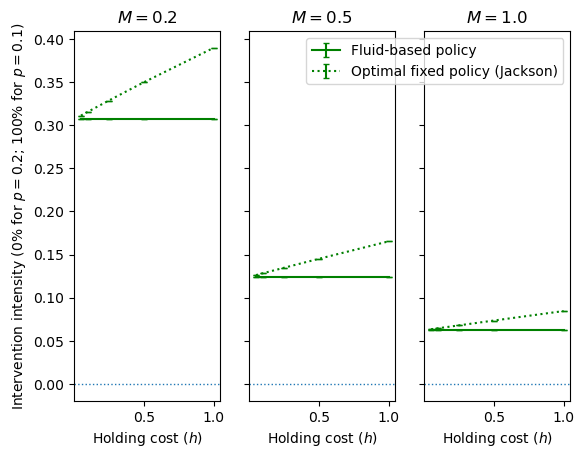

In [42]:

fig, axes = plt.subplots(1, len(Ms), sharey=True)
for i, M in enumerate(Ms):
    ax = axes[i]
    subset = new_df[(new_df.M == M)].sort_values(by='h')
    ax.errorbar(subset.h, (0.2 - subset.p_eq)/0.1 , yerr=subset.p_ci_eq/0.1,
                capsize=2,
                color=grays[0],
                label="Fluid-based policy")
    ax.errorbar(subset.h, (0.2 - subset.p_jackson)/0.1 , yerr=subset.p_ci_jackson/0.1,
               capsize=2,
               color=grays[0],
               linestyle=':',
                label="Optimal fixed policy (Jackson)")
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Holding cost ($h$)")
    
    if i == 0:
        ax.set_ylabel("Intervention intensity (0% for $p=0.2$; 100% for $p=0.1$)")
    ax.title.set_text(r'$M={}$'.format(M))
    
    if i == 2:
        ax.legend()

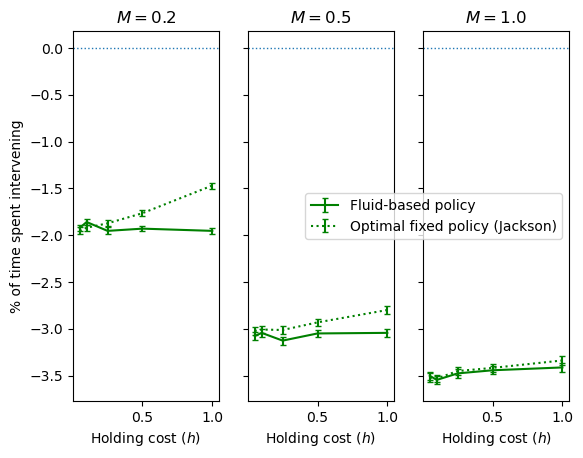

In [43]:

fig, axes = plt.subplots(1, len(Ms), sharey=True)
for i, M in enumerate(Ms):
    ax = axes[i]
    subset = new_df[(new_df.M == M)].sort_values(by='h')
    ax.errorbar(subset.h, (0.2 - subset.p_time_eq)/0.1 , yerr=subset.p_time_ci_eq/0.1,
                capsize=2,
                color=grays[0],
                label="Fluid-based policy")
    ax.errorbar(subset.h, (0.2 - subset.p_time_jackson)/0.1 , yerr=subset.p_time_ci_jackson/0.1,
               capsize=2,
               color=grays[0],
               linestyle=':',
                label="Optimal fixed policy (Jackson)")
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Holding cost ($h$)")
    if i == 0:
        ax.set_ylabel("% of time spent intervening")
    ax.title.set_text(r'$M={}$'.format(M))
    
    if i == 2:
        ax.legend()

## Mean Congestion

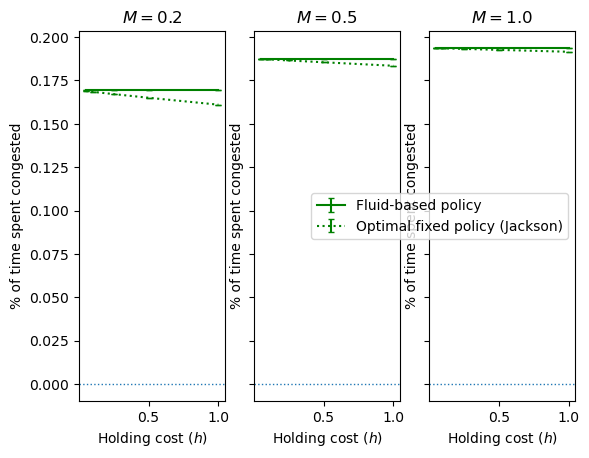

In [44]:

fig, axes = plt.subplots(1, len(Ms), sharey=True)
for i, M in enumerate(Ms):
    ax = axes[i]
    subset = new_df[(new_df.M == M)].sort_values(by='h')
    ax.errorbar(subset.h, subset.cong_time_eq, yerr=subset.cong_time_ci_eq,
                capsize=2,
                color=grays[0],
                label="Fluid-based policy")
    ax.errorbar(subset.h, subset.cong_time_jackson, yerr=subset.cong_time_ci_jackson,
               capsize=2,
               color=grays[0],
               linestyle=':',
                label="Optimal fixed policy (Jackson)")
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Holding cost ($h$)")
    ax.set_ylabel("% of time spent congested")
    ax.title.set_text(r'$M={}$'.format(M))
    
    if i == 2:
        ax.legend()

## Performance Plot

### Line styles:
- Solid: fluid policy vs equilibrium policy
- Dot/dash: fluid safety policy vs equilbirium policy
- Dash: fluid policy vs simple policy
- Dot: fluid safety policy vs simple policy

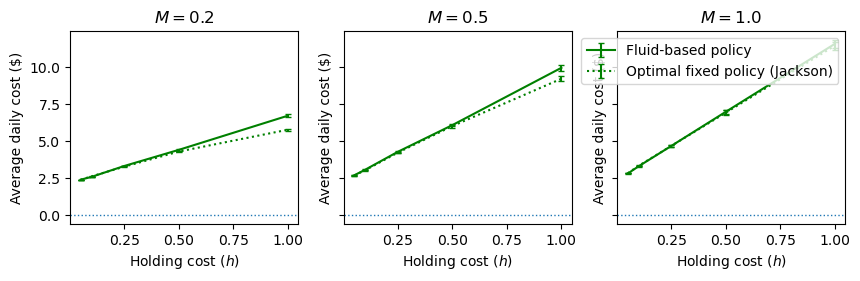

In [50]:
# Plot all together, for Python interpretation
fig, axes = plt.subplots(1, len(Ms), sharey=True)
for i, M in enumerate(Ms):
    ax = axes[i]
    subset = new_df[(new_df.M == M)].sort_values(by='h')
    ax.errorbar(subset.h, subset.eq_mean, yerr=subset.eq_ci,
                capsize=2,
                color=grays[0],
                label="Fluid-based policy")
    ax.errorbar(subset.h, subset.jackson_mean, yerr=subset.jackson_ci,
               capsize=2,
               color=grays[0],
               linestyle=':',
                label="Optimal fixed policy (Jackson)")
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Holding cost ($h$)")
    ax.set_ylabel("Average daily cost ($)")
    ax.title.set_text(r'$M={}$'.format(M))
    
    if i == 2:
        ax.legend()

fig.set_figheight(2.5)
fig.set_figwidth(10)

plt.savefig(outdir + "figs/{}.png".format(typ), bbox_inches='tight')